# Neural Networks: Multilayer Perceptron (MLP) with PyTorch

- Neural Networks can have a massice number of parameters, with dozens of layers, meaning the model will have a lot of work to learn and optimize everything!
- Well, this is exactly Deep Learning 
- To help this networks building, Pytorch has a module called `nn`


In [1]:
# for better image plotting
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np

import torch
from torchvision import datasets, transforms
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns

from collections import OrderedDict

In [3]:
# defining transforms for data normalization 
transform = transforms.Compose([transforms.ToTensor(),                  # setting PIL image --> pytorch tensor
                                transforms.Normalize((0.5,), (0.5,))])   # B/W only have 2 channels

batch_size = 64

transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,))])   # normalize only 2 channels bc it's a B&W picture

# Download and load the training data
trainset = datasets.MNIST('./data', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

### We created a  `trainloader` and now we'll pass an _iterator_ `iter(trainloader)`:

```python
for image, label in trainloader:
    ## do things with images and labels
```

### Note that the batch_size here is 64, so let's check it out the first batch:
- `images` is a vector with size `(64, 1, 28, 28)`, that means, 64 images / batch, $1$ color per channel  (RBG it woulb be 3 channels), the the size of the images are 28x28 pixels.

In [4]:
data_iter = iter(trainloader)
images, labels = data_iter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


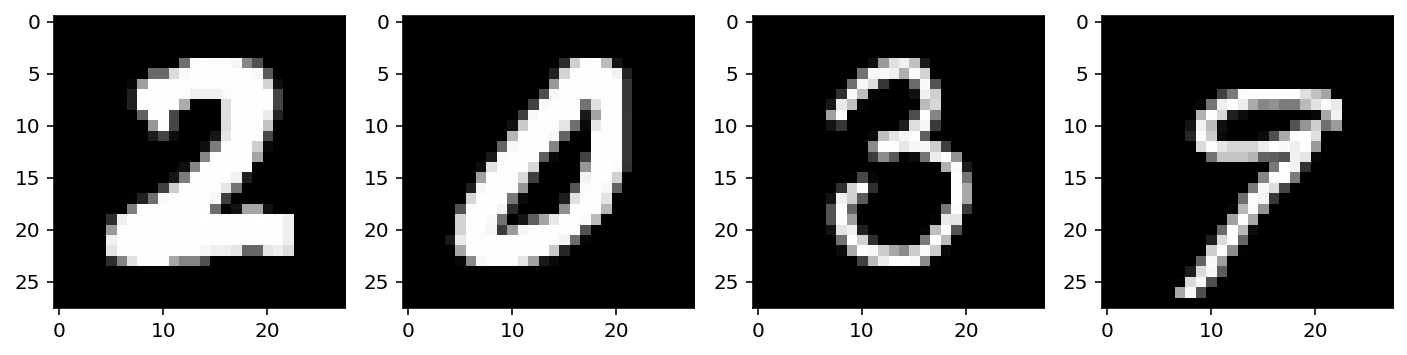

In [7]:
fig, ax = plt.subplots(1, 4, figsize=(12,4))
for i in range(4):
    ax[i].imshow(images[i].numpy().squeeze(), cmap='Greys_r');

## To understand the theory behind neural networks, I'll first build one using matrix multiplication
- After, I'll use the module `nn`

## MLP layers:
- are called *fully-connected* or *dense*
- all units from one layer are connected to all units from the next layer
- The input from each layer must be a 1D vector
- So, in the MNIST example here, the 28x28 px images will be converted to tensors of 784 units
- Thus, the tensor: `(64, 1, 28, 28)` will be converted to: `(64, 784)`
- This procedure is called *flattening* ( 2Dtensor -------> 1Dtensor )

## At this example, we have the **input**, one **hidden** and the **output** layers:

In [8]:
## activation function
def sigmoid(x):
    return 1/(1 + torch.exp(-x))

# Flattening: keeps the first dimension (64), which is the batch_size and transforms the other dimension in one
inputs =  images.view(images.shape[0],-1)

# defining the weights that connect the input layer to the hidden layer
W1 = torch.randn(inputs.shape[1] , 256)         ###  Note that the hidden layer has 256 neurons:

# defining the weights that connect the hidden layer to the output layer
W2 = torch.randn(256, 10)             ### Note that the output layer has 10 neurons (=classify 10 digits)

# defining the bias term: first fot the hidden layer and than for the output layer (same number of neurons)
B1 = torch.randn(256)
B2 = torch.randn(10)

# compute the hidden layer terms passing the activation function:
h = sigmoid(torch.mm(inputs,W1) + B1)        ### mm: matrix multiplication

# computes the network output:
out = torch.mm(h,W2) + B2                

## With those 10 outputs, we want to know which class does the image belong to
- Thus, we compute the probability associated with each class
- This probability is computed with the function **Softmax**, defined as:

$$
\Large \sigma(x_i) = \cfrac{e^{x_i}}{\sum_k^K{e^{x_k}}}
$$

- This function _squeezes_ the output to values between 0 and 1
- Then, the value is normalized 
- The sum of the probabilities (of each class) is always going to be = 1

## Defining the Softmax functiona according to the equation above:
- dim = 1 : the sum is going through each class, not through each sample
- The softmax returns a tensor with 64x10, that means for each image (from the batch) the class which it belongs to

In [9]:
def softmax(x):
    """Defining the Softmax function."""
    return torch.exp(x)/torch.sum(torch.exp(x),dim = 1).view(-1,1)

In [10]:
# probabilities is the output of the softmax size: (64,10) 
probabilities = softmax(out)

print(probabilities.shape)

torch.Size([64, 10])


In [11]:
# Checking the sum of the all the probabilities for 10 classes == 1
print(probabilities.sum(dim=1))

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])


## Building the network with `nn` pytorch
- creating a class called `Network` which inherits from `nn.module`
- parameters: 
- `nn.Linear`: Applies a linear transformation to the incoming data:
    - self.hidden : input is **28x28pixels** to **256** at the hidden layer
        - This module creates the **weights** and **bias** tensors
        - These new tensors will be used in `forward` method 
        - To check these tensors out we can:
            - Instantiate the network and pass `net.hidden.weight` and `net.hidden.bias`.
    
    - self.output : **256** from the hidden to **10** in output
    - sigmoid and softmax (again passing dim = 1): defining the activation and output functions  
- `Forward` method:
    - receives "x" and passes the tensor for each operation

In [12]:
from torch import nn

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        # linear transformation 784 from input layer to 256 at the hidden layer 
        self.hidden = nn.Linear(784, 256)
        # again, from hidden to output
        self.output = nn.Linear(256, 10)
        
        # Define Sigmoid and Softmax functions
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        # the forward method passes the x tensor through each operation
        x = self.hidden(x)
        x = self.sigmoid(x)
        x = self.output(x)
        x = self.softmax(x)
        return x

In [13]:
# creating the network
model = Network()
model

Network(
  (hidden): Linear(in_features=784, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=1)
)

## Creating the Network class in a much easier way

In [14]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(784, 256)
        self.output = nn.Linear(256, 10)
        
    def forward(self, x):
        x = F.sigmoid(self.hidden(x))
        x = F.softmax(self.output(x), dim=1)
        return x

### Since [Helper](https://github.com/udacity/deep-learning-v2-pytorch/blob/master/intro-to-pytorch/helper.py) is not working here, I copied the function `view_classify` from the original file:

In [15]:
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

### Ativation Function

- the only requirement for a function to be used as activation function, is to be **non-linear**!
- common activation functions:
    1)  Tanh (hyperbolic tang)
    2)  Sigmoid
    3)  ReLU (rectified linear unit)


- ReLU is almost always used as activation function for hidden layers

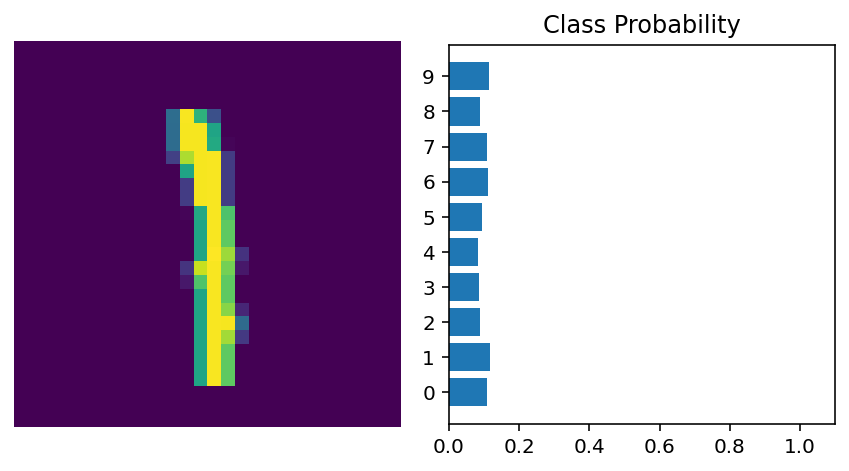

In [16]:
# obtaining some images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Reshaping this images to 1D vector 
#    New size: (batch_size, color channels, pixels) 
images.resize_(64, 1, 784)
# OR images.resize_(images.shape[0], 1, 784) it takes the batch_size automatically

# Pass the forward method 
img_idx = 2
ps = model.forward(images[img_idx,:])

img = images[img_idx]
# View the image and the barplot of each class probability
view_classify(img.view(1, 28, 28), ps)

## As we can see here, our network doensn't know what digit is this, yet
- the network was initialized with random weights


### Using `nn.Sequential`
- the module [`nn.Sequential`](https://pytorch.org/docs/master/nn.html#torch.nn.Sequential) helps to build simple networks, where the tensor goes through operations, passing from one to another sequentially
- We can use this module to build a similar network:

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): Softmax(dim=1)
)


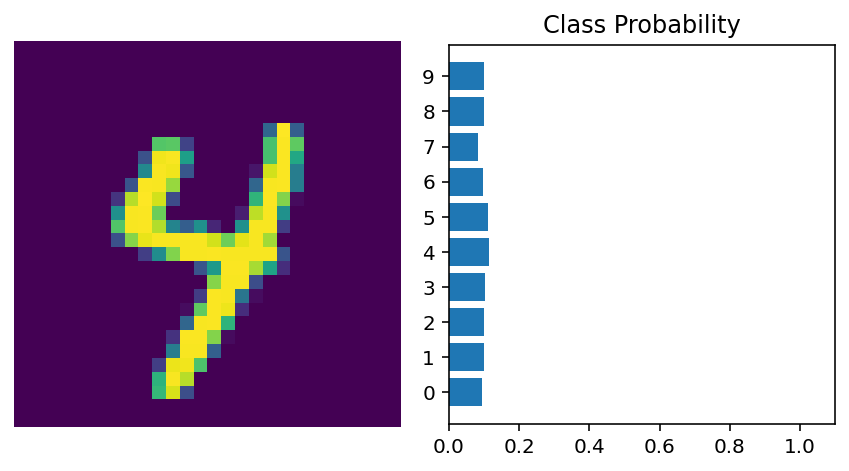

In [17]:
# Network Hyperparameters 
input_size = 784   
hidden_sizes = [128, 64]
output_size = 10

# feed-forward network           # input       # output
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.Softmax(dim=1))
print(model)

# Forward step from one sample through the network; showing the output
images, labels = next(iter(trainloader))
images.resize_(images.shape[0], 1, 784)
ps = model.forward(images[0,:])
view_classify(images[0].view(1, 28, 28), ps)

### - Our network still doensn't know what digit is this. 
- That's why we have to train out network and teach it what each digit looks like

### MODEL:
- input units: 784
- hidden layers: 128
- Activation function: ReLU
- Another hidden layer: 64
- Activation function: ReLU
- Output layer: 10 (1 class per digit)
- Softmax


In [20]:
# loiking at the operations inside the model 
print('First operation:\033[31m', model[0])
print('\033[mSecond operation:\033[31m',model[1])
print('\033[mThird operation:\033[31m',model[2])
print('\033[m...')

First operation: Linear(in_features=784, out_features=128, bias=True)
Second operation: ReLU()
Third operation: Linear(in_features=128, out_features=64, bias=True)
...


In [21]:
print('\033[mWeights:\033[32m',model[0].weight)

Weights: Parameter containing:
tensor([[ 0.0042,  0.0179,  0.0178,  ...,  0.0252, -0.0075,  0.0122],
        [-0.0062,  0.0342, -0.0249,  ..., -0.0201, -0.0004, -0.0347],
        [ 0.0160, -0.0116, -0.0262,  ...,  0.0026, -0.0324, -0.0047],
        ...,
        [-0.0042, -0.0030, -0.0026,  ..., -0.0355,  0.0047,  0.0068],
        [ 0.0123, -0.0208,  0.0304,  ..., -0.0073, -0.0245, -0.0112],
        [ 0.0282,  0.0037, -0.0350,  ...,  0.0285,  0.0250,  0.0267]],
       requires_grad=True)


In [22]:
print('\033[mBias:\033[32m',model[0].bias)

Bias: Parameter containing:
tensor([ 0.0115, -0.0120, -0.0193, -0.0297, -0.0123,  0.0166, -0.0100, -0.0314,
         0.0141, -0.0155,  0.0164, -0.0041, -0.0101,  0.0108, -0.0040, -0.0055,
         0.0257, -0.0167, -0.0070,  0.0067, -0.0254,  0.0112, -0.0308, -0.0336,
        -0.0333,  0.0054,  0.0288, -0.0352, -0.0134, -0.0240, -0.0112,  0.0258,
        -0.0149,  0.0188,  0.0139, -0.0351,  0.0340,  0.0158, -0.0209,  0.0141,
        -0.0162, -0.0052,  0.0123, -0.0110, -0.0188, -0.0343, -0.0271, -0.0176,
         0.0285,  0.0313, -0.0031,  0.0090,  0.0161, -0.0038, -0.0099, -0.0097,
         0.0133,  0.0051,  0.0169, -0.0099,  0.0140,  0.0320, -0.0226, -0.0202,
         0.0232, -0.0168,  0.0062, -0.0095, -0.0327,  0.0285,  0.0224,  0.0212,
         0.0289,  0.0329,  0.0121, -0.0137, -0.0133,  0.0280,  0.0252, -0.0345,
        -0.0165,  0.0018, -0.0216,  0.0163, -0.0074,  0.0352, -0.0267, -0.0062,
        -0.0116, -0.0204,  0.0213, -0.0344, -0.0021, -0.0139,  0.0054, -0.0052,
         0.0

## Using `OrderedDict` to organize the sequential operations
- we can individually name each layer

In [23]:
model = nn.Sequential(OrderedDict([
                      ('fc1', nn.Linear(input_size, hidden_sizes[0])),
                      ('relu1', nn.ReLU()),
                      ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
                      ('relu2', nn.ReLU()),
                      ('output', nn.Linear(hidden_sizes[1], output_size)),
                      ('softmax', nn.Softmax(dim=1))]))
model

Sequential(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=64, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

In [24]:
print(model[0])
print(model.fc1)

Linear(in_features=784, out_features=128, bias=True)
Linear(in_features=784, out_features=128, bias=True)


In [25]:
print(model[4])
print(model.output)

Linear(in_features=64, out_features=10, bias=True)
Linear(in_features=64, out_features=10, bias=True)


# Training the Neural Network
- **loss function:** identify how our network is performing 
    - Mean squared error (MSE):

$$
\large \ell = \frac{1}{2n}\sum_i^n{\left(y_i - \hat{y}_i\right)^2}
$$


>   $n$: number of training samples
>
>   $y_i$ real labels
>
>   $\hat{y}_i$ estimated labels

- The network make some adjustments in the weights to minimize the Loss
- In order to find MIN(loss), we use _Gradient Descent_ 
- The gradient is the derivative vector 

## Backpropagation
- It is easier to implement the gradient descent in One-layer networks
- To deeper networks, it's more complicated; With that in mind, researchers developed the step **Backpropagation**
- we need to choose the learning rate ($\alpha$) so that the update of the weights, at each step, is small enough for the method to iteratively reach the minimum loss value.

## Loss function in PyTorch
- using `nn` module, we can find a lot of loss functions
- one example is the `nn.CrossEntropyLoss`
- this function is usually used as `criterion`
- multi-class classification (such as MNIST), we use Softmax to precit each class probability
- to calculate the error itself, we must define some creterions and define the correct labels to out network

Note that:

> the criterion matches `nn.LogSoftmax()` and `nn.NLLLoss()` at a single class.
>
> The output must be a specific format (logit).

Isso significa que precisamos passar diretamente a saída da rede para computar o _loss_, em vez de fornecer a saída após passar pela função Softmax. Essa saída direta (antes da Softmax) é chamada *logit* ou *scores*. Usamos os logits porque as probabilidades fornecidas pela Softmax ficam muito próximas de 0 ou 1. ([leia mais aqui](https://docs.python.org/3/tutorial/floatingpoint.html)). Ou seja, é melhor evitar calculos usando probabilidades, uma vez que é mais comum usar o log das probabilidades.

In [26]:
trainloader

In [27]:
# feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10))

# Loss function
criterion = nn.CrossEntropyLoss()

# iterating through the images and labels
images, labels = next(iter(trainloader))

# flattening the image (2D to 1D)
images = images.view(images.shape[0], -1)

# Forward pass
logits = model(images)

# Calculating the error for logits and labels
loss = criterion(logits, labels)

print(loss)

tensor(2.3035, grad_fn=<NllLossBackward>)


## Output function: `nn.LogSoftmax` or `F.log_softmax` 
- Then, we obtain the real probabilities using the exponential `torch.exp(output)`
- With log-softmax output, we can compute the _negative log likelihood_, `nn.NLLLoss` , which is equivalet to the output of `nn.CrossEntropyLoss`. 

>**Exercício:** build a model that returns the log-softmax as output and calculate the loss using _negative log likelihood_. 
>
> Note that for `nn.LogSoftmax` and `F.log_softmax` you need to set the parameter `dim` correctly. 
> 
> * `dim=0` computes softmax by rows, add +1 in the columns
>
> * `dim=1` computes softmax by columns, add +1 in the rows
> 
> Think about the output and choose the correct `dim`

In [28]:
# feed-forward network with the output log-softmax
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]), 
                      (nn.ReLU()), 
                      (nn.Linear(hidden_sizes[0], hidden_sizes[1])), 
                      (nn.ReLU()),
                      (nn.Linear(hidden_sizes[1], output_size)),
                      (nn.LogSoftmax(dim=1)))

# defining the loss function negative log likelihood
criterion = nn.NLLLoss()

# getting the images and labels from trainloader
images, labels = next(iter(trainloader))
# flattening the image
images = images.view(images.shape[0], -1)

# Forward pass, getting the logps
logps = model(images)

# calculating the loss
loss = criterion(logps, labels)

print(loss)

tensor(2.3038, grad_fn=<NllLossBackward>)


## Autograd

- Now, let's use the _loss_ in backpropagation
- PyTorch has the module `autograd` that computes the gradientes
    - `autograd` stores the operations performed on each tensor
    - then passes it back calculating the gradients
    - Just to be sure that pytorch is actually sroting the operations, it's important to set `requires_grad = True` in the tensor
    - To do it so, we can call `requires_grad` or at any time write `x.requires_grad_(True)`

- It's also possible to deactivate the gradients calling `torch.no_grad()`:
- Also, we can turn it ON of OFF the storage of all gradients at the same time using `torch.set_grad_enabled(True|False)`.

- The gradients are related to a variable like `z`, with `z.backward()`

### Creating rando  numbers from a normal distribution with mean = `0` and variance = `1`:

In [29]:
x = torch.randn(2,2, requires_grad=True)
print(x)

tensor([[ 1.3246,  0.6318],
        [-0.9723, -0.1335]], requires_grad=True)


In [30]:
y = x**2
print(y)

tensor([[1.7547, 0.3992],
        [0.9454, 0.0178]], grad_fn=<PowBackward0>)


- PowBackward0: it says that a squared operation created `y`

### The autograd module keeps track of these operations
- and knows how to compute the gradient of each one
- thus, it can compute the gradient for chain operations

### Computing the mean:

In [31]:
z = y.mean()
print(z)

tensor(0.7793, grad_fn=<MeanBackward0>)


In [32]:
print(x.grad)
print(y.grad)

None
None


<ipython-input-32-cd4c40187c02>:2: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more information.
  print(y.grad)


### The proper way of computing the gradient is by executing the `.backward` in `z`
- This will compute the gradient of `z` related to `x`, like:

$$
\frac{\partial z}{\partial x} = \frac{\partial}{\partial x}\left[\frac{1}{n}\sum_i^n x_i^2\right] = \frac{x}{2}
$$

In [33]:
z.backward()
print('\033[mGradient:\033[31m', x.grad)
print('\033[mx / 2:\033[31m', x/2)

Gradient: tensor([[ 0.6623,  0.3159],
        [-0.4862, -0.0667]])
x / 2: tensor([[ 0.6623,  0.3159],
        [-0.4862, -0.0667]], grad_fn=<DivBackward0>)


## Merging Loss and Autograd 
- When creating a network with pytorch, every parameter is initialized with `requires_grad = True`
- That means that when we call `loss.backward()`, the gradients of each parameter are calculated
- These gradients are used to update the weights during gradient descent
 
### Using _backward pass_:

In [34]:
# feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logits = model(images)
loss = criterion(logits, labels)

In [35]:
print('Before backward pass: \n', model[0].weight.grad)

loss.backward()

print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[-0.0023, -0.0023, -0.0023,  ..., -0.0023, -0.0023, -0.0023],
        [ 0.0034,  0.0034,  0.0034,  ...,  0.0034,  0.0034,  0.0034],
        [-0.0018, -0.0018, -0.0018,  ..., -0.0018, -0.0018, -0.0018],
        ...,
        [-0.0011, -0.0011, -0.0011,  ..., -0.0011, -0.0011, -0.0011],
        [ 0.0009,  0.0009,  0.0009,  ...,  0.0009,  0.0009,  0.0009],
        [-0.0063, -0.0063, -0.0063,  ..., -0.0063, -0.0063, -0.0063]])


## Training the Neural Network!
- The last key here, is to select the optimizer that will be uldating the weights with gradient
- There are some in the [`optim` package](https://pytorch.org/docs/stable/optim.html). 
- Let's try using the stochastic gradient descent (SGD) with `optim.SGD`

In [36]:
# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01)

### Training:

* Forward 
* Use the output to compute the error (_loss_)
* Backward with `loss.backward()` to calculate the gradients
* Use the optimizer to update the weights

> Let's train the network and print the changes in the gradients;
>
> `optimizer.zero_grad()` at each iteration (because they accumulate at each backward);
>
> Knowing that, we must zero the grads at each iteration to avoid further accumulation.

In [37]:
print('\033[mInitial weights:\033[31m', model[0].weight)

images, labels = next(iter(trainloader))
images.resize_(64, 784)

# zero the accumulated grads
optimizer.zero_grad()

# Forward, backward, and update the weights
output = model(images)
loss = criterion(output, labels)
loss.backward()
print('\033[mGradient:\033[31m', model[0].weight.grad)

Initial weights: Parameter containing:
tensor([[-0.0099, -0.0259, -0.0350,  ...,  0.0052,  0.0235,  0.0288],
        [ 0.0228,  0.0031,  0.0300,  ..., -0.0120, -0.0298,  0.0330],
        [-0.0099, -0.0341, -0.0133,  ..., -0.0290, -0.0070, -0.0302],
        ...,
        [ 0.0299, -0.0346,  0.0083,  ..., -0.0146, -0.0193,  0.0106],
        [-0.0332,  0.0318,  0.0049,  ..., -0.0305, -0.0087, -0.0331],
        [ 0.0146,  0.0258,  0.0168,  ..., -0.0334,  0.0040,  0.0342]],
       requires_grad=True)
Gradient: tensor([[ 0.0032,  0.0032,  0.0032,  ...,  0.0032,  0.0032,  0.0032],
        [-0.0042, -0.0042, -0.0042,  ..., -0.0042, -0.0042, -0.0042],
        [-0.0002, -0.0002, -0.0002,  ..., -0.0002, -0.0002, -0.0002],
        ...,
        [ 0.0010,  0.0010,  0.0010,  ...,  0.0010,  0.0010,  0.0010],
        [-0.0023, -0.0023, -0.0023,  ..., -0.0023, -0.0023, -0.0023],
        [ 0.0020,  0.0020,  0.0020,  ...,  0.0020,  0.0020,  0.0020]])


In [38]:
# Step that update the weights
optimizer.step()
print('\033[mUpdated weights:\033[31m', model[0].weight)

Updated weights: Parameter containing:
tensor([[-0.0099, -0.0259, -0.0350,  ...,  0.0051,  0.0234,  0.0288],
        [ 0.0228,  0.0032,  0.0300,  ..., -0.0120, -0.0298,  0.0331],
        [-0.0099, -0.0341, -0.0133,  ..., -0.0290, -0.0070, -0.0302],
        ...,
        [ 0.0299, -0.0347,  0.0083,  ..., -0.0146, -0.0193,  0.0106],
        [-0.0332,  0.0318,  0.0050,  ..., -0.0305, -0.0087, -0.0331],
        [ 0.0146,  0.0257,  0.0168,  ..., -0.0334,  0.0040,  0.0341]],
       requires_grad=True)


## Training: now it's for real!!!

- EPOCH: is when we pass through all samples
- Let's iterate through `trainloader` to use out training batches
- For each batch the error is calculated and the backpropagation step update the weights


In [39]:
## Sua solução vai aqui
# defining the model
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))
# Criterion
criterion = nn.NLLLoss()
# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01)


# TODO: defina o modelo, o critério e o atualizador

epochs = 5
for e in range(epochs):
    running_loss = 0
    
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
     
        # zero the accumulated grads
        optimizer.zero_grad()

        # Forward, backward, and update the weights
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 1.009742727983735
Training loss: 0.38593429581983
Training loss: 0.32734962540076995
Training loss: 0.29461358466159815
Training loss: 0.26883152753178247


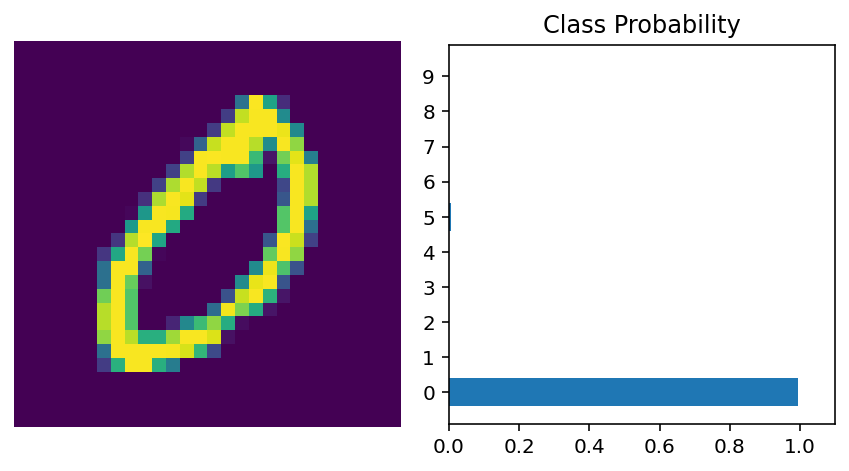

In [40]:
images, labels = next(iter(trainloader))

img = images[0].view(1, 784)
# gradient OFF
with torch.no_grad():
    logps = model(img)

# We need the exp to see the real predictions
ps = torch.exp(logps)
view_classify(img.view(1, 28, 28), ps)

## GREAT! Our model works :)

# Creating a Neutal Network model from scratch
### 1) NeuralNetwork Class 
- inherits from the `nn.Module`
- `__init__` defines the layers: input, 2 hidden and output
- method `forward` receives x, flatten the tensor, passes the activation function (ReLU) for each layer, and the output layer is computed with `log_softmax`, passing the columns (dim=1).
### 2) NeuralNetwork_reg Class
- `__init__` defines the layers: input, 2 hidden and output; and defines the regularization `dropout` with probability of 0.2
- method `forward` receives x, flatten the tensor, passes the activation function (ReLU) inside the `dropout` regularization function (which will deactivate 20% of the neurons at each iteration, to help balance the weights properlly) for each layer, and the output layer is computed as before, passing the `log_softmax` (dim=1).

## Creating a function `model_pipeline` to evaluate different scenarios
1) transformations: 
    1) `ToTensor()` 
    
    2) `RandomHorizontalFlip`
    
     ![RandomHorizontalFlip](https://pytorch.org/vision/stable/_images/sphx_glr_plot_transforms_020.png)
     
    3) `RandomRotation` 
    
     ![RandomRotation](https://pytorch.org/vision/stable/_images/sphx_glr_plot_transforms_009.png)
     
    4) `RandomPerspective`
    
     ![RandomPerspective](https://pytorch.org/vision/stable/_images/sphx_glr_plot_transforms_008.png)

In [63]:
# NeuralNetwork class Inherit from nn.Module
## --> without regularization

class NeuralNetwork(nn.Module):
    def __init__(self): 
        super().__init__()
        # defining the layers and neurons
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # flattening the tensor
        x = x.view(x.shape[0], -1)
        # forward step
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [64]:
## ---> With regularization: Dropout

class NeuralNetwork_reg(nn.Module):
    def __init__(self): 
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # flattening the tensor
        x = x.view(x.shape[0], -1)
        # forward step
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [78]:
def model_pipeline(dataset = 'KMNIST', horizontal_flip=False, flip_percentage=0.5,              # transformations
                   random_rotation=False, rotation_degree=20, 
                   random_perspective=False, distortion_scale=0.6, 
                   validation_size=0.2, reg=False, loss = 'cross', optimizer = 'adam',   # model parameters
                   batch_size=200, epochs = 5, lr_rate=0.002):                            
    
    """This function builds and trains a neural network model.
    ---> dataset: downloads the training and test sets dependind on the dataset passed as a string.
         - options: 'KMNIST', 'MNIST', 'FashionMNIST'; (). 
    ---> Transforms:
        1) horizontal_flip: True or False (default = False).
        - flip_percentage: probability of the image being flipped (default = 0.5).
        2) random_rotation: True or False (default = False).
        - rotation_degree: degree that the image will rotate (default = 20).
        3) random_perspective: True or False (default = False).
        - distortion_scale: argument to control the degree of distortion and ranges from 0 to 1 (default = 0.6).
   ---> Model, Loss and Optimizer:
        4) validation_size: size of the train samples that will be used to validate the model (default = 0.2).
        5) reg: True or False (default = False)| If the model will be defined with or without regularization.
        6) Loss functions: passed as a string. Options: "cross", "poiss", "gauss", "nll".
        7) Optimizer functions: passed as a string. Options: "adam", "adamax", "asgd".
   ---> Other parameters:
        8) batch_size: number of batches to pass into the dataloader (default = 200).
        9) epochs: defining the number of epochs (default = 5).
        10) lr_rate: the rate that the SGD will learn and reduce the loss function (default = 0.002).
        """ 
    ### creating transform pipeline
    if horizontal_flip:
        transformations = transforms.Compose([transforms.RandomHorizontalFlip(flip_percentage)])
    if random_rotation:
        transformations = transforms.Compose([transforms.RandomRotation(rotation_degree)])
    if random_perspective:
        transformations = transforms.Compose([transforms.RandomPerspective(distortion_scale)])

    transformations = transforms.Compose([transforms.ToTensor(),
                                          transforms.Normalize((0.5,), (0.5,))])
    
    ### Downloading the training and test data dependind on the dataset variable passed as a string
    if dataset == 'MNIST':
        train_dataset = datasets.MNIST('./data', download=True, train=True, transform=transform)
        test_dataset = datasets.MNIST('./data/', download=True, train=False, transform=transform)
    elif dataset == 'KMNIST':
        train_dataset = datasets.KMNIST('./data', download=True, train=True, transform=transform)
        test_dataset = datasets.KMNIST('./data/', download=True, train=False, transform=transform)
    elif dataset == 'FashionMNIST':
        train_dataset = datasets.FashionMNIST('./data', download=True, train=True, transform=transform)
        test_dataset = datasets.FashionMNIST('./data/', download=True, train=False, transform=transform)
    
    # Get the size of our train set
    training_size = len(train_dataset)

    # then, we create a list of indices from 0 to training size range
    indices = list(range(training_size))

    # Shuffling the indices
    np.random.shuffle(indices)

    # The shuffled index will split the validation and training datasets using numpy "floor" method:
    index_split = int(np.floor(training_size * validation_size))  # floor of the scalar `x` is the largest integer

    # Then, we get the training and validation set indices passing the index split 
    validation_indices, training_indices = indices[:index_split], indices[index_split:]

    # Using SubsetRandomSampler we sample elements randomly from a list of indices
    training_sample = SubsetRandomSampler(training_indices)
    validation_sample = SubsetRandomSampler(validation_indices)
   
    ### creating the data loader, passing the sampler created above
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=training_sample)
    valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=validation_sample)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
    
    ### defining the model with or without regularization
    if reg:       # if True the model will be instantiated with regularization (dropout)
        model = NeuralNetwork_reg()
    elif reg == False:         # if False, the model won't have regularization
        model = NeuralNetwork()
        
    ### LOSS
    if loss == 'cross':
        criterion = nn.CrossEntropyLoss() 
    elif loss == 'poiss':
        criterion = nn.PoissonNLLLoss() 
    elif loss == 'gauss':
        criterion = nn.GaussianNLLLoss()
    elif loss == 'nll':
        criterion = nn.NLLLoss()
    
    ### OPTIMIZER
    if optimizer == 'adam':    
        optimizer = optim.Adam(model.parameters(), lr=lr_rate)
    if optimizer == 'adamax': 
        optimizer = optim.Adamax(model.parameters(), lr=lr_rate)
    if optimizer == 'asgd': 
        optimizer = optim.ASGD(model.parameters(), lr=lr_rate)
    
    ### Training the NN
    train_losses, test_losses = [], []
    for e in range(epochs):
        running_loss = 0
        for image, label in train_loader:
            optimizer.zero_grad()
            log_ps = model(image)
            loss = criterion(log_ps, label)
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()
        else:
            test_loss = 0
            accuracy = 0
            with torch.no_grad():
                model.eval()
                for image, label in test_loader:         
                    log_ps = model.forward(image)
                    prob = torch.exp(log_ps)
                    test_loss+= criterion(log_ps, label)
                    k_prob, k_class = prob.topk(1, dim=1)
                    equals = k_class == label.view(*k_class.shape)
                    accuracy+= torch.mean(equals.type(torch.FloatTensor))
            model.train()
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))
        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training Loss: {:.3f}...".format(train_losses[-1]),
              "Test Loss: {:.3f}...".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))
        
    ### Showing the image and the probability barplot   
    images, labels = next(iter(trainloader))

    img = images[0].view(1, 784)
    # gradient OFF
    with torch.no_grad():
        logps = model(img)

    # We need the exp to see the real predictions
    ps = torch.exp(logps)
    view_classify(img.view(1, 28, 28), ps)
    
    return (accuracy/len(test_loader)), train_losses, test_losses

## Testing the classes and the function with KMNIST:

Epoch: 1/10... Training Loss: 0.694... Test Loss: 0.759... Test Accuracy: 0.755
Epoch: 2/10... Training Loss: 0.332... Test Loss: 0.617... Test Accuracy: 0.810
Epoch: 3/10... Training Loss: 0.243... Test Loss: 0.517... Test Accuracy: 0.840
Epoch: 4/10... Training Loss: 0.185... Test Loss: 0.463... Test Accuracy: 0.863
Epoch: 5/10... Training Loss: 0.148... Test Loss: 0.434... Test Accuracy: 0.874
Epoch: 6/10... Training Loss: 0.120... Test Loss: 0.438... Test Accuracy: 0.882
Epoch: 7/10... Training Loss: 0.097... Test Loss: 0.420... Test Accuracy: 0.886
Epoch: 8/10... Training Loss: 0.081... Test Loss: 0.448... Test Accuracy: 0.882
Epoch: 9/10... Training Loss: 0.065... Test Loss: 0.449... Test Accuracy: 0.887
Epoch: 10/10... Training Loss: 0.055... Test Loss: 0.489... Test Accuracy: 0.876


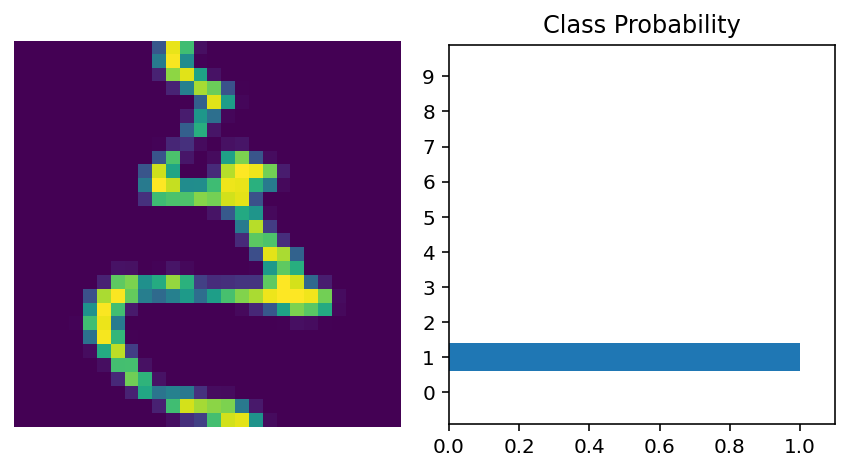

In [68]:
acc, train_loss, test_loss = model_pipeline(random_perspective=True, distortion_scale=0.8, optimizer='adamax', epochs=10, lr_rate=0.002)

## Testing the classes and the function with MNIST:

Epoch: 1/10... Training Loss: 0.591... Test Loss: 0.325... Test Accuracy: 0.903
Epoch: 2/10... Training Loss: 0.284... Test Loss: 0.247... Test Accuracy: 0.924
Epoch: 3/10... Training Loss: 0.221... Test Loss: 0.192... Test Accuracy: 0.943
Epoch: 4/10... Training Loss: 0.182... Test Loss: 0.156... Test Accuracy: 0.951
Epoch: 5/10... Training Loss: 0.146... Test Loss: 0.134... Test Accuracy: 0.959
Epoch: 6/10... Training Loss: 0.125... Test Loss: 0.119... Test Accuracy: 0.962
Epoch: 7/10... Training Loss: 0.106... Test Loss: 0.118... Test Accuracy: 0.963
Epoch: 8/10... Training Loss: 0.093... Test Loss: 0.106... Test Accuracy: 0.966
Epoch: 9/10... Training Loss: 0.081... Test Loss: 0.102... Test Accuracy: 0.969
Epoch: 10/10... Training Loss: 0.072... Test Loss: 0.088... Test Accuracy: 0.972


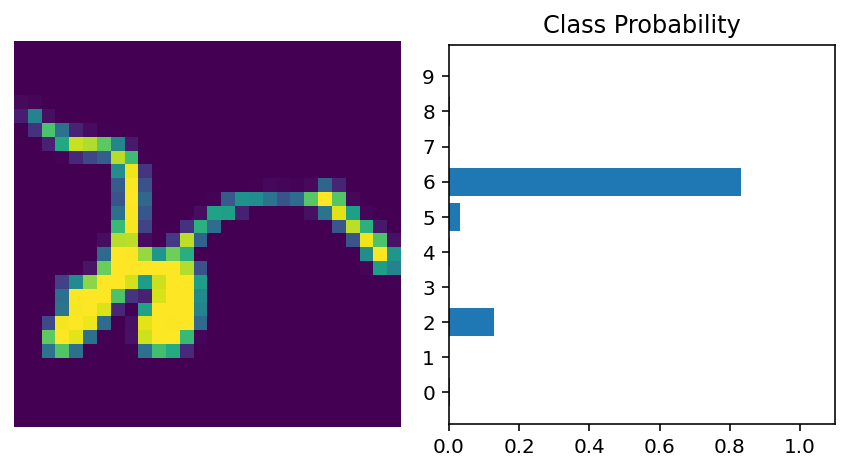

In [77]:
acc, train_loss, test_loss = model_pipeline(dataset='MNIST', random_perspective=True, distortion_scale=0.8, optimizer='adamax', epochs=10, lr_rate=0.002)

In [ ]:
acc, train_loss, test_loss = model_pipeline(dataset='FashionMNIST', random_perspective=True, distortion_scale=0.8, optimizer='adamax', epochs=10, lr_rate=0.002)

Epoch: 1/10... Training Loss: 0.640... Test Loss: 0.489... Test Accuracy: 0.822
Epoch: 2/10... Training Loss: 0.433... Test Loss: 0.443... Test Accuracy: 0.839
Epoch: 3/10... Training Loss: 0.386... Test Loss: 0.405... Test Accuracy: 0.853
Epoch: 4/10... Training Loss: 0.355... Test Loss: 0.398... Test Accuracy: 0.857
Epoch: 5/10... Training Loss: 0.330... Test Loss: 0.369... Test Accuracy: 0.868
Epoch: 6/10... Training Loss: 0.313... Test Loss: 0.368... Test Accuracy: 0.866
